In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,r2_score

In [284]:
data_g=pd.read_excel('./Data Science Test/Train.xlsx')

In [285]:
data_g.info()
data_g[['Volume']].describe()
data_g.head(10)
data_g.loc[:,'Time_data']=pd.to_datetime(data_g['YearMonth'],format='%Y%m')
if 'Time_data' in data_g.columns:
    data_g.set_index('Time_data',inplace=True)
train,test=36,12
data_req=data_g[['Volume']].copy()
#print(adfuller(data_req['Volume'].apply(lambda x:np.log(x)).values))
data_req.shape
x_up,x_low=np.percentile(data_req['Volume'],[95,5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
Company_ID    48 non-null object
Product_ID    48 non-null object
YearMonth     48 non-null int64
Volume        48 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ KB


In [286]:
print(x_up,x_low)
data_req['Volume']=data_req['Volume'].apply(lambda x: x_up if x>x_up else x)
data_req['Volume']=data_req['Volume'].apply(lambda x: x_low if x<x_low else x)
data_req.describe().T

31.70292 9.81078


count       mean       std      min      25%      50%      75%  \
Volume   48.0  17.541608  5.875919  9.81078  13.1904  16.6298  20.2776   

             max  
Volume  31.70292

Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index. 

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

When I applied log on volumes data it DickeyFuller unit root test failed saying time series is not depend on it older values.
Since Dickey_Fuller unit root test is passed we can say future values are based on older datapoints on timeseries data

In [287]:
#Testing with given data using Augmented Dickey-Fuller unit root test to know whether any unit root is available with data
# Null hyp
for i in [11,23,35,47]:
    p_valu_adf=adfuller(data_req['Volume'][0:i].apply(lambda x:x).values,regression='ctt',autolag='AIC')[1]
    if p_valu_adf<0.05:
        print("This time series data has no unit root, so its non-stationary series. P Value is {}".format(p_valu_adf))
    else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has unit root. P Value is 0.9989573259007248
This time series data has unit root. P Value is 0.9989573259007248
This time series data has no unit root, so its non-stationary series. P Value is 0.0355899288874824
This time series data has unit root. P Value is 0.10804071689982664


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [288]:
for i in [11,23,35,47]:
    p_valu_adf=adfuller(data_req['Volume'][0:i].apply(lambda x:np.log(x)).values,autolag='AIC')[1]
    if p_valu_adf<0.05:
        print("This time series data has no unit root, so its non-stationary series. P Value is {}".format(p_valu_adf))
    else:
        print("This time series data has unit root. P Value is {}".format(p_valu_adf))

This time series data has unit root. P Value is 0.958532086060056
This time series data has no unit root, so its non-stationary series. P Value is 0.00012396975878152698
This time series data has no unit root, so its non-stationary series. P Value is 0.0003417471578779563
This time series data has no unit root, so its non-stationary series. P Value is 0.002799755325328718


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


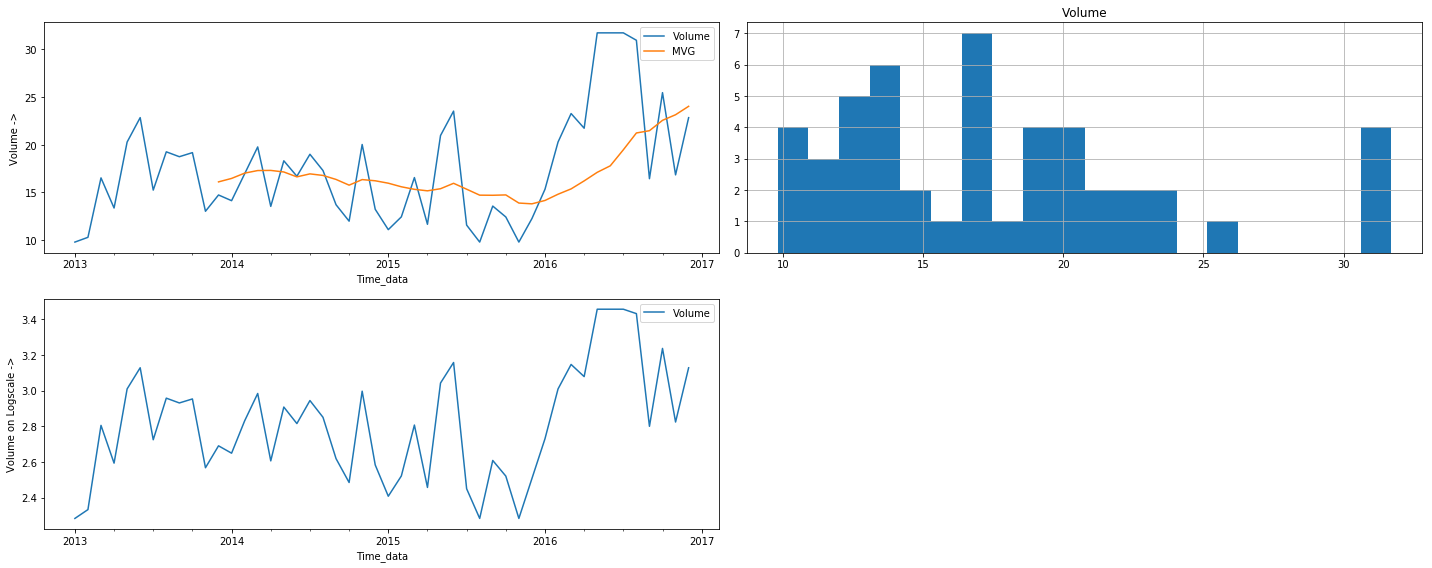

In [289]:
data_req.loc[:,'MVG']=data_req['Volume'].rolling(12).mean() #moving average at 12 months 
fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(221)
data_req[['Volume']].plot(ax=ax1)
ax1.set_ylabel("Volume ->")
ax2=fig.add_subplot(222)
data_req[['Volume']].hist(bins=20,ax=ax2)
data_req[['MVG']].plot(ax=ax1)
data_year=data_req.resample('3M',label='right').mean()
ax3=fig.add_subplot(223)
#data_year[['Volume']].plot(ax=ax1)
data_req[['Volume']].apply(lambda x:np.log(x)).plot(ax=ax3)
ax3.set_ylabel("Volume on Logscale ->")
fig.tight_layout()

In [290]:
data_req.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).T
#data_year.info()

count       mean       std        min         1%         5%  \
Volume   48.0  17.541608  5.875919   9.810780   9.810780   9.985227   
MVG      37.0  16.876637  2.544069  13.813563  13.842759  14.111383   

              10%      25%      50%      75%        90%        95%        99%  \
Volume  11.444640  13.1904  16.6298  20.2776  24.094710  31.431558  31.702920   
MVG     14.715938  15.3443  16.2254  17.1465  21.323235  22.667682  23.699714   

              max  
Volume  31.702920  
MVG     24.016505

In [67]:
data_req.head(20).T

Time_data  2013-01-01  2013-02-01  2013-03-01  2013-04-01  2013-05-01  \
Volume          7.668     10.3092     16.5288     13.3764     20.2776   
MVG               NaN         NaN         NaN         NaN         NaN   

Time_data  2013-06-01  2013-07-01  2013-08-01  2013-09-01  2013-10-01  \
Volume        22.8336     15.2508     19.2552      18.744       19.17   
MVG               NaN         NaN         NaN         NaN         NaN   

Time_data  2013-11-01  2013-12-01  2014-01-01  2014-02-01  2014-03-01  \
Volume        13.0356     14.7396     14.1432     16.9548     19.7664   
MVG               NaN     15.9324     16.4720     17.0258     17.2956   

Time_data  2014-04-01  2014-05-01  2014-06-01  2014-07-01  2014-08-01  
Volume        13.5468     18.3180     16.6992     18.9996     17.2956  
MVG           17.3098     17.1465     16.6353     16.9477     16.7844

In [291]:
r2_score_mvg,rmse_mvg=np.sqrt(mean_squared_error(data_req.iloc[11:35,0],data_req.iloc[11:35,1])),r2_score(data_req.iloc[11:,0],data_req.iloc[11:,1])
print("With Moving Averge prediction method for each 12 month, RMSE is {:.4f} and R square error is {:.4f}".format(rmse_mvg,r2_score_mvg))

With Moving Averge prediction method for each 12 month, RMSE is 0.2071 and R square error is 3.3779


**Details about Data**
This data has 48 months of sales information.
Understanding the Problem Statement and Dataset
Installing library (statsmodels)
Method 1 – Start with a Naive Approach
Method 2 – Simple average
Method 3 – Moving average
Method 4 – Single Exponential smoothing
Method 5 – Holt’s linear trend method
Method 6 – Holt’s Winter seasonal method
Method 7 – ARIMA

0.441921612964


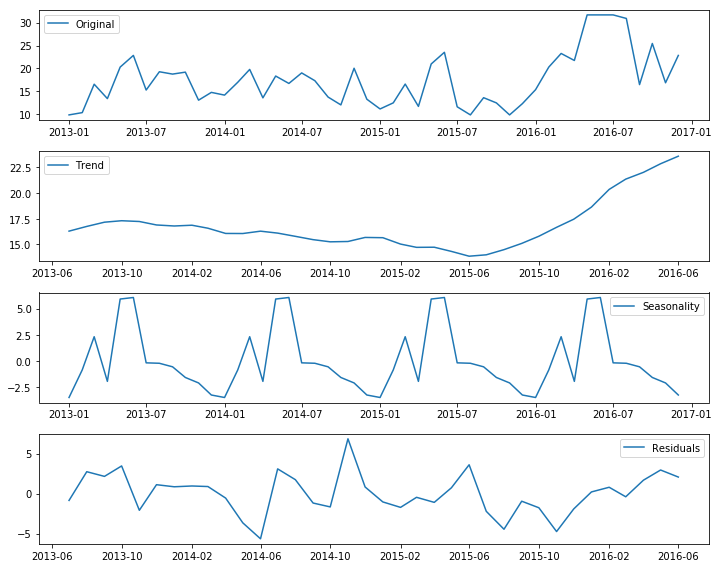

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_req[['Volume']])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(data_req['Volume'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

data_q=pd.DataFrame(data=residual)
data_q=data_q.dropna()
p_valu_adf=adfuller(data_q['Volume'].values,regression='ctt',autolag='AIC')[1]
print(p_valu_adf)

In [149]:
from statsmodels.tsa.stattools import acf, pacf

In [293]:
lag_acf = acf(data_req['Volume'], nlags=14)
lag_pacf = pacf(data_req['Volume'], nlags=14, method='ols')
x=(-1.96/np.sqrt(data_req['Volume'].shape[0]),0,1.96/np.sqrt(data_req['Volume'].shape[0]))

Text(0.5,1,'Partial Auto Correlation Function plot')

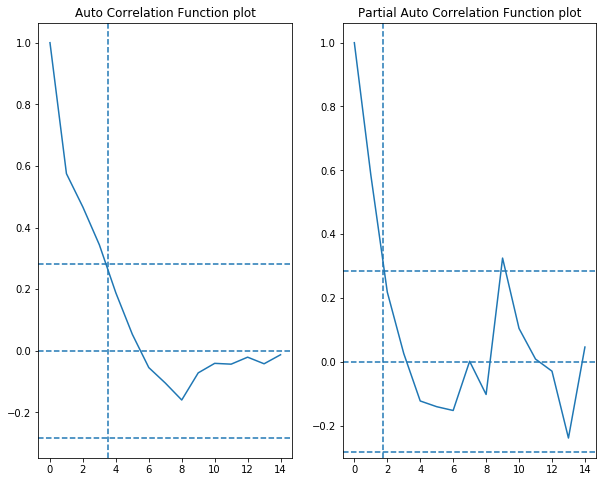

In [324]:
fig= plt.figure(figsize=(10,8))
ax1=fig.add_subplot(121)
ax1.plot(lag_acf)
ax1.axhline(x[1],linestyle='--')
ax1.axhline(x[0],linestyle='--')
ax1.axhline(x[2],linestyle='--')
ax1.axvline(3.5,linestyle='--')
ax1.set_title('Auto Correlation Function plot')
ax2=fig.add_subplot(122)
ax2.plot(lag_pacf)
ax2.axhline(x[1],linestyle='--')
ax2.axhline(x[0],linestyle='--')
ax2.axhline(x[2],linestyle='--')
ax2.axvline(1.75,linestyle='--')
ax2.set_title('Partial Auto Correlation Function plot')

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=3 or 4.

858.3740857


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-1.4620948767342941

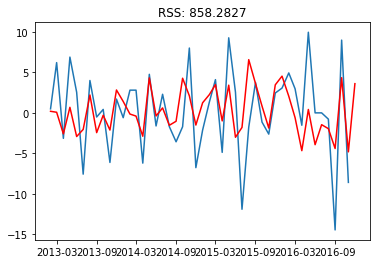

In [335]:
i=47
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data_req['Volume'],order=(5,1,5))
results_ARIMA=model.fit(disp=-1)
log_diff=data_req['Volume'][0:i]-data_req['Volume'][0:i].shift()
plt.plot(log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.sum((results_ARIMA.fittedvalues[1:i]-log_diff[1:i])**2))
data_check=pd.concat([log_diff,results_ARIMA.fittedvalues],axis=1)
data_check.columns=['Y','y_pred']
data_check['diff']=(data_check['y_pred']-data_check['Y'])**2
print(np.sum(data_check['diff']))
data_check_2=data_check.dropna()
r2_score(data_check_2['y_pred'],data_check_2['Y'])

In [338]:
data_check=pd.concat([log_diff,results_ARIMA.fittedvalues],axis=1)
data_check.columns=['Y','y_pred']
data_check['diff']=(data_check['y_pred']-data_check['Y'])**2
print(np.sum(data_check['diff']))
data_check_2=data_check.dropna()
r2_score(data_check_2['y_pred'],data_check_2['Y'])

858.3740857


-1.4620948767342941

-2.5899018504582849

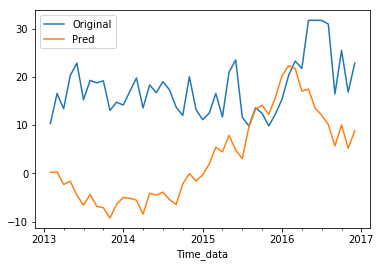

In [347]:
data_check=pd.concat([log_diff,results_ARIMA.fittedvalues],axis=1)
data_check.columns=['Diff','Diff_pred']
data_check.loc[:,'Pred']=data_check['Diff_pred'].cumsum()
data_check.loc[:,'Original']=data_req['Volume'][1:]
data_check[['Original','Pred']].plot()
data_check_2=data_check.dropna()
r2_score(data_check_2['Pred'],data_check_2['Original'])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


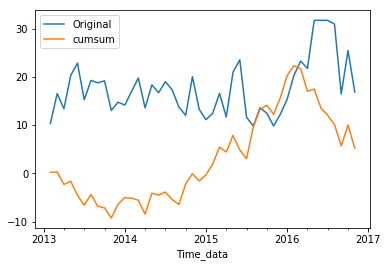

In [183]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
#dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = data_req[['Volume']].values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

const  ar.L1.D.Volume  ar.L2.D.Volume  ma.L1.D.Volume  \
const           2.254412e-01        0.000003    1.023883e-07        0.002268   
ar.L1.D.Volume  2.808761e-06       -0.000030   -1.174542e-06        0.000023   
ar.L2.D.Volume  1.023883e-07       -0.000001   -1.524491e-10        0.000001   
ma.L1.D.Volume  2.267855e-03        0.000023    1.161719e-06        0.018715   
ma.L2.D.Volume  1.229787e-03        0.000021   -4.145564e-07        0.009843   
ma.L3.D.Volume  2.269267e-03        0.000032   -6.838489e-09        0.018849   

                ma.L2.D.Volume  ma.L3.D.Volume  
const             1.229787e-03    2.269267e-03  
ar.L1.D.Volume    2.082963e-05    3.248168e-05  
ar.L2.D.Volume   -4.145564e-07   -6.838489e-09  
ma.L1.D.Volume    9.843458e-03    1.884858e-02  
ma.L2.D.Volume    4.539352e-03    1.051230e-02  
ma.L3.D.Volume    1.051230e-02    1.858235e-02

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
r2_score(testY[0], testPredict[:,0]),mean_squared_error(testY[0], testPredict[:,0])